# Intro

In this project different methods and algorithms of image quantization are shown

# Algorithms

In [1]:
!pip install opencv-python

In [24]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math as m

# img_source = 'images/gradient.jpg'
# img_source = 'images/grad_2.jpeg'

# img_source = 'images/otto.png'


# img_source = 'images/hills.jpeg'
img_source = 'images/hills-underscaled.png'

# img_source = 'images/example.png'
# img_source = 'images/example_underscaled.png'

# img_source = 'images/me.jpg'

**View images:**

In [23]:
# img = cv2.imread(img_source)
# # plt.imshow(img)

# gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# # plt.imshow(gray_image, cmap='gray')

# height, width, channels = img.shape
# print(f"Width: {width} pixels")
# print(f"Height: {height} pixels")
# print(f"Number of channels: {channels}")
# print(f"Image size: {img.size} bytes")
# print(f"Image data type: {img.dtype}")

# plt.figure(figsize=(10,5))

# plt.subplot(1,2,1)
# plt.imshow(img)
# plt.title('Original')
# plt.axis('off')

# plt.subplot(1,2,2)
# plt.imshow(gray_image, cmap='gray')
# plt.title('Gray image')
# plt.axis('off')


## Uniform image quantization

### Gray

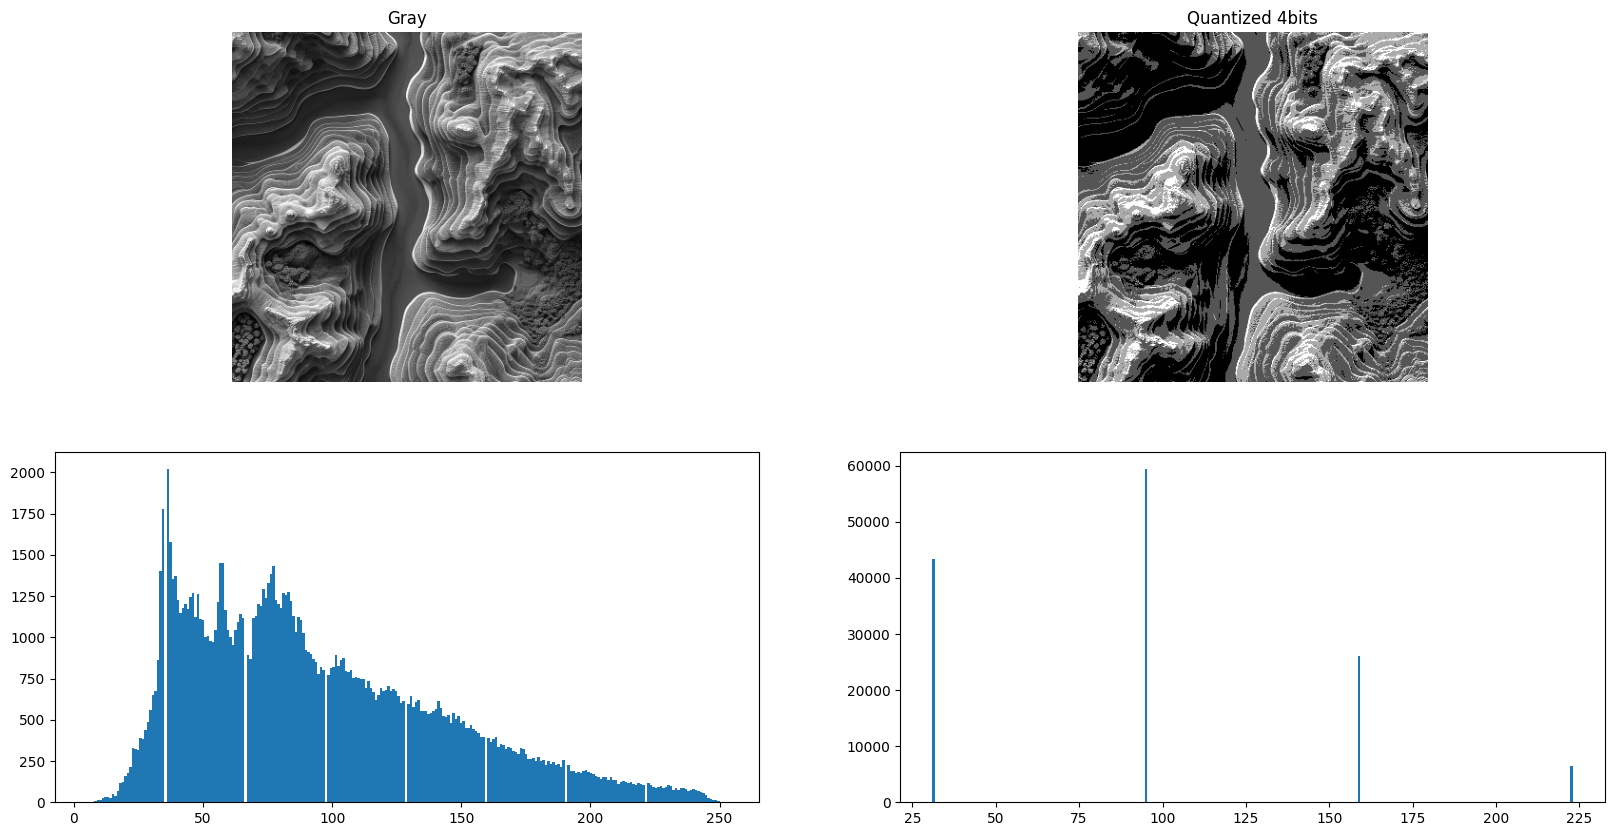

In [28]:
level = 4

img = cv2.imread(img_source)
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
quantized_image = np.array(gray_image).copy()
delta = 255/level
for i in range(gray_image.shape[0]):
    for j in range(gray_image.shape[1]):
        quantized_image[i][j] = int(np.floor(gray_image[i][j]/delta)*delta+delta/2)

plt.figure(figsize=(20,10))


plt.subplot(2,2,1)
plt.imshow(gray_image, cmap='gray')
plt.title('Gray')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(quantized_image, cmap='gray')
plt.title(f'Quantized {level}bits')
plt.axis('off')


plt.subplot(2,2,3)
_=plt.hist(gray_image.ravel(), bins=256)

plt.subplot(2,2,4)
_=plt.hist(quantized_image.ravel(), bins=256)

### Color

C:\Users\glebo\AppData\Local\Temp\ipykernel_8844\1369921857.py:8: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 286 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  quantized_image[i][j] = int(np.floor(channel[i][j]/delta)*delta+delta/2)


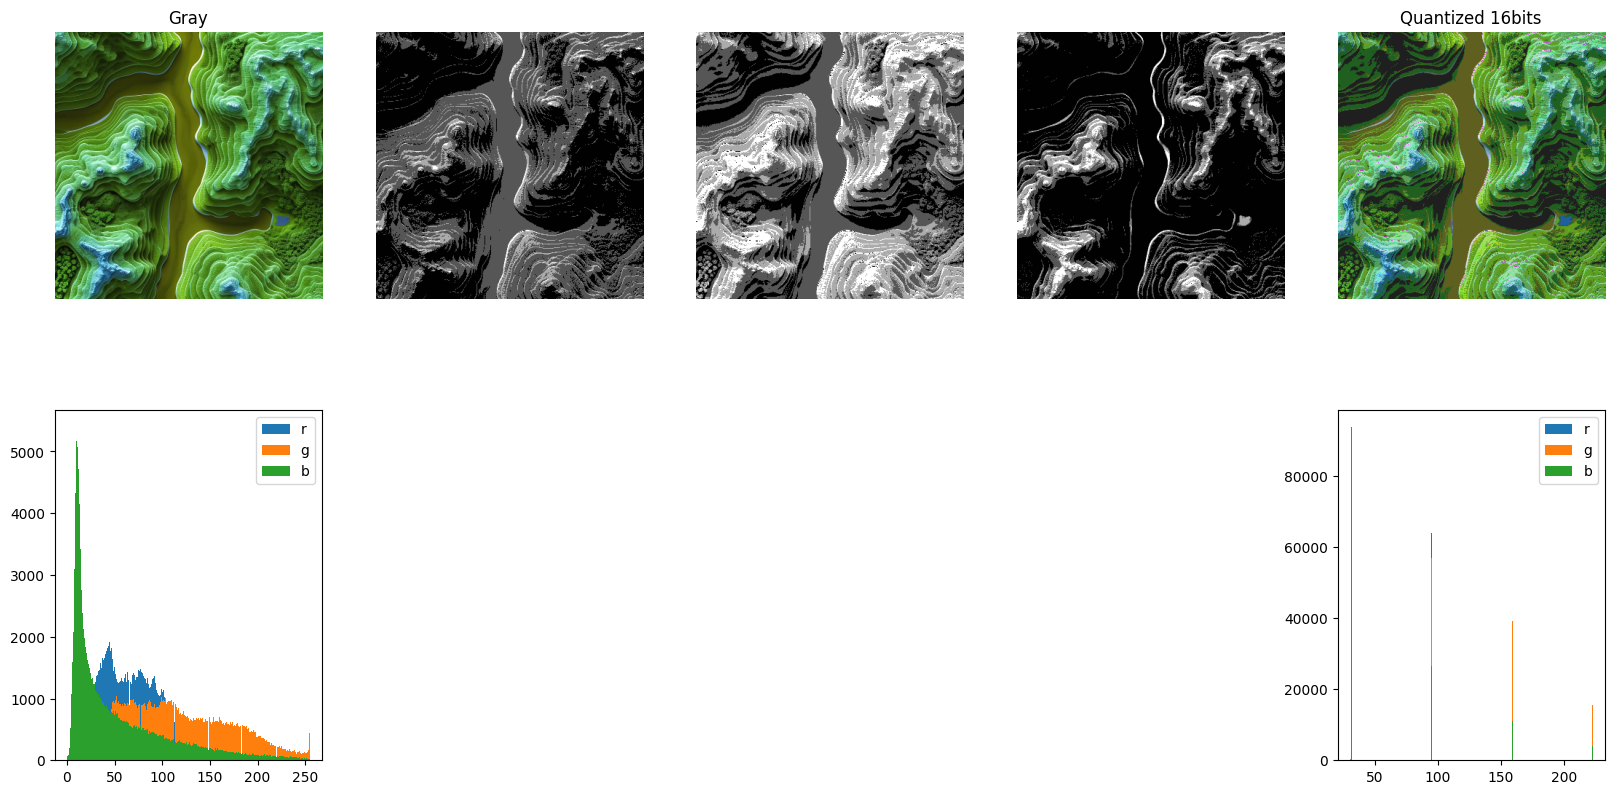

In [35]:
level = 4

def u_quantize(channel):
    delta = 255/level
    quantized_image = channel.copy()
    for i in range(channel.shape[0]):
        for j in range(channel.shape[1]):
            quantized_image[i][j] = int(np.floor(channel[i][j]/delta)*delta+delta/2)
    return quantized_image
    
image = cv2.imread(img_source)
r,g,b = cv2.split(image)
channels = [r,g,b]
n_c = []
for channel in channels:
    n_c.append(u_quantize(channel))
quantized_image = cv2.merge(n_c)


plt.figure(figsize=(20,10))

plt.subplot(2,5,1)
plt.imshow(image, cmap='gray')
plt.title('Gray')
plt.axis('off')

plt.subplot(2,5,2)
plt.imshow(n_c[0], cmap='gray')
plt.axis('off')
plt.subplot(2,5,3)
plt.imshow(n_c[1], cmap='gray')
plt.axis('off')
plt.subplot(2,5,4)
plt.imshow(n_c[2], cmap='gray')
plt.axis('off')

plt.subplot(2,5,5)
plt.imshow(quantized_image)
plt.title(f'Quantized {2**level}bits')
plt.axis('off')


plt.subplot(2,5,6)
_=plt.hist(cv2.split(image)[0].ravel(), bins=256)
_=plt.hist(cv2.split(image)[1].ravel(), bins=256)
_=plt.hist(cv2.split(image)[2].ravel(), bins=256)
plt.legend(['r','g','b'])

plt.subplot(2,5,10)
_=plt.hist(cv2.split(quantized_image)[0].ravel(), bins=256)
_=plt.hist(cv2.split(quantized_image)[1].ravel(), bins=256)
_=plt.hist(cv2.split(quantized_image)[2].ravel(), bins=256)
plt.legend(['r','g','b'])

# cv2.imwrite('images/gray_hills.jpeg',gray_image)
# cv2.imwrite('images/quantized_gray_hills.jpeg',quantized_image)

## Median cut quantization

Median cut uses median color to split the range of colors into two and have average by them. Depth is used to identify amount of colors are wanted in result.

>Algorithm:
>1. Flatten image into one single array
>2. Find color with highest range
>3. Sort by this color
>4. Take median
>5. Split into buckets by median and repeat until desired depth
>6. For final 0-depth buckets define average color and set for image


https://web.archive.org/web/20190202154003/http://www.leptonica.com/papers/mediancut.pdf \
https://www.researchgate.net/publication/26339916_Optimal_image_quantization_perception_and_the_median_cut_algorithm

In [5]:
import matplotlib.pyplot as plt
import numpy as np


def median_cut_quantize(img, img_arr): # set average color in bucket
    r_average = np.mean(img_arr[:,0])
    g_average = np.mean(img_arr[:,1])
    b_average = np.mean(img_arr[:,2])
    for data in img_arr:
        img[data[3]][data[4]] = [r_average, g_average, b_average]

# finding max-range color, sort by it to take median -> split into buckets by this median. Resulting with 2^depth buckets (colors)
def split_into_buckets(img, img_arr, depth): 
    if len(img_arr) == 0:
        return 
        
    if depth == 0:
        median_cut_quantize(img, img_arr)
        return
    
    r_range = np.max(img_arr[:,0]) - np.min(img_arr[:,0])
    g_range = np.max(img_arr[:,1]) - np.min(img_arr[:,1])
    b_range = np.max(img_arr[:,2]) - np.min(img_arr[:,2])
    max_range_space = (0 if r_range*2>g_range+b_range else 1 if g_range*2>b_range+r_range else 2)

    # sort by color
    img_arr = img_arr[img_arr[:,max_range_space].argsort()]
    median_index = int((len(img_arr)+1)/2) # bucket split index
    # print("median_index:", median_index)

    
    # split by median
    split_into_buckets(img, img_arr[0:median_index], depth-1)
    split_into_buckets(img, img_arr[median_index:], depth-1)

Initial number of colors: 40538
Resulting number of colors: 16
unique: [[122  88 254]
 [125 136 254]
 [140 201 254]
 [163  82 254]
 [163 213 254]
 [167 156 254]
 [186 215 251]
 [191 235 250]
 [203  66 182]
 [211 151 175]
 [215 216 182]
 [215 238 189]
 [231 214 126]
 [240 201  88]
 [245 126  79]
 [247 176  69]]


Text(0.5, 1.0, 'Histogram 4bits')

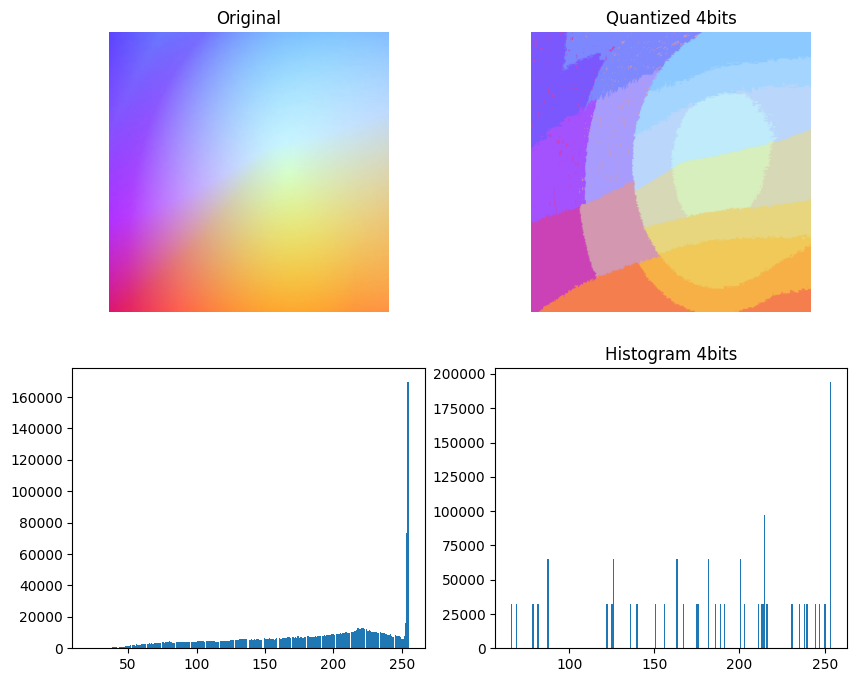

In [6]:
image = cv2.imread(img_source)
bits = 4

# list of pixels with their positions in image
flattened_img_array = []
for row_index, rows in enumerate(image):
    for color_index, color in enumerate(rows):
        flattened_img_array.append([color[0],color[1],color[2], row_index, color_index]) 
# print('len',len(flattened_img_array))


plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.imshow(image, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(2,2,3)
_=plt.hist(image.ravel(), bins=256)
print('Initial number of colors:', np.unique(image.reshape(-1, image.shape[-1]), axis=0).shape[0])

flattened_img_array = np.array(flattened_img_array)
split_into_buckets(image, flattened_img_array, bits)

plt.subplot(2,2,2)
plt.imshow(image,cmap='gray')
plt.title(f'Quantized {bits}bits')
plt.axis('off')

# print(np.unique(image.reshape(-1, image.shape[-1]), axis=0))
print('Resulting number of colors:', np.unique(image.reshape(-1, image.shape[-1]), axis=0).shape[0])
print('unique:',np.unique(image.reshape(-1, image.shape[-1]), axis=0))
plt.subplot(2,2,4)
_=plt.hist(image.ravel(), bins=256)
plt.title(f'Histogram {bits}bits')

## Random dithering 1 bit

True

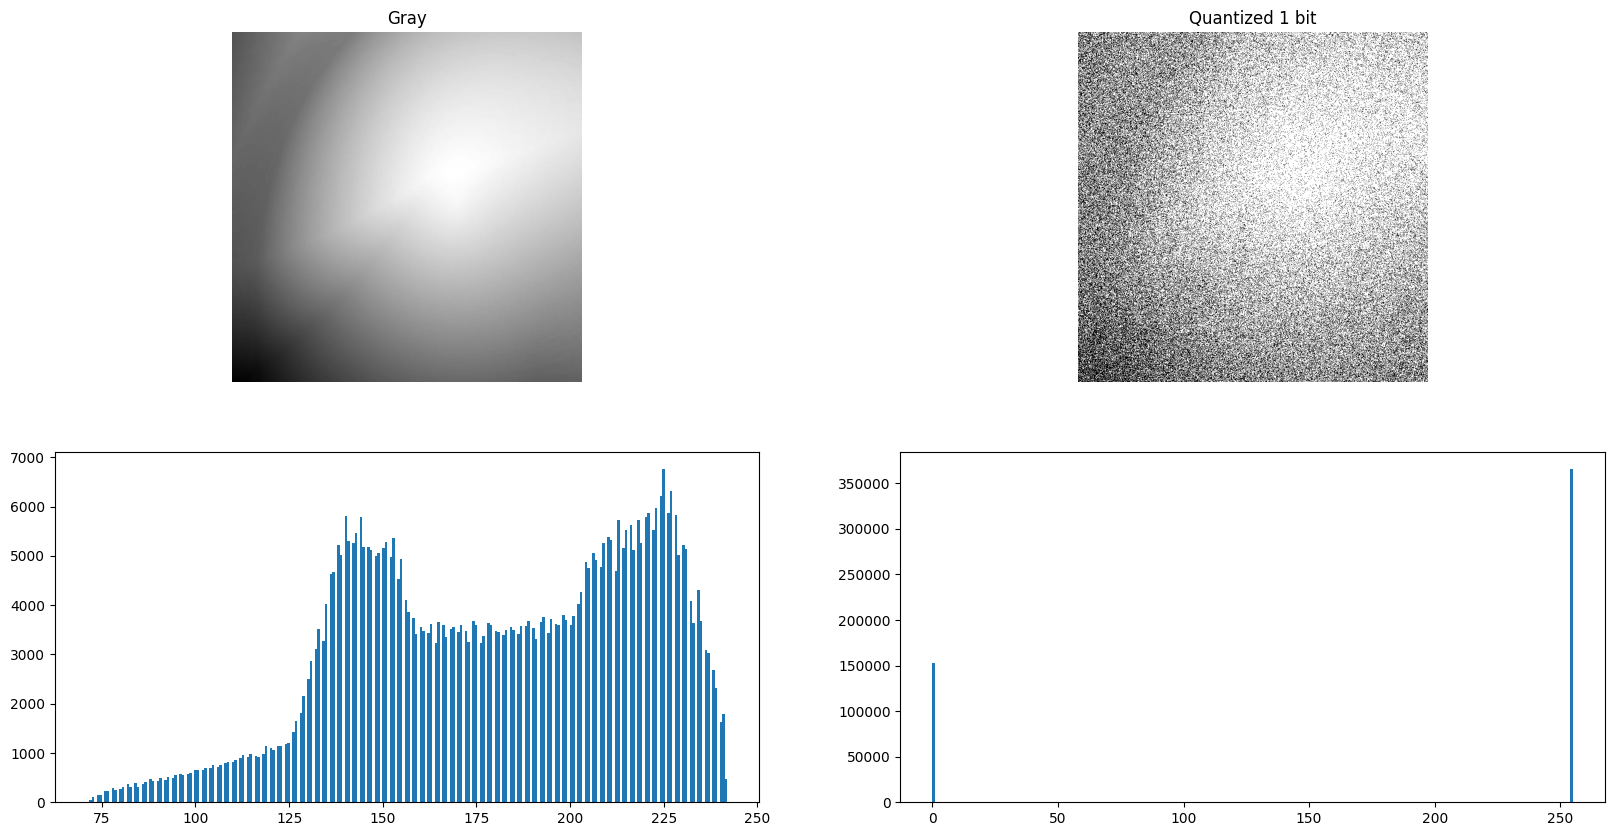

In [7]:
# level = 2
treshold = 127

image = cv2.imread(img_source)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

quantized_image = np.array(gray_image).copy()
# delta = 255/level
for i in range(gray_image.shape[0]):
    for j in range(gray_image.shape[1]):
        # quantized_image[i][j] = int(np.floor(gray_image[i][j]/delta)*delta+delta/2 + np.random.randint(-127,127))
        # quantized_image[i][j] = 255 if gray_image[i][j]>treshold else 0
        quantized_image[i][j] = 255 if gray_image[i][j]+np.random.randint(-127,127)>treshold else 0

plt.figure(figsize=(20,10))


plt.subplot(2,2,1)
plt.imshow(gray_image, cmap='gray')
plt.title('Gray')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(quantized_image, cmap='gray')
plt.title(f'Quantized 1 bit')
plt.axis('off')


plt.subplot(2,2,3)
_=plt.hist(gray_image.ravel(), bins=256)

plt.subplot(2,2,4)
_=plt.hist(quantized_image.ravel(), bins=256)

cv2.imwrite('images/gray_hills.jpeg',gray_image)
cv2.imwrite('images/quantized_gray_hills.jpeg',quantized_image)

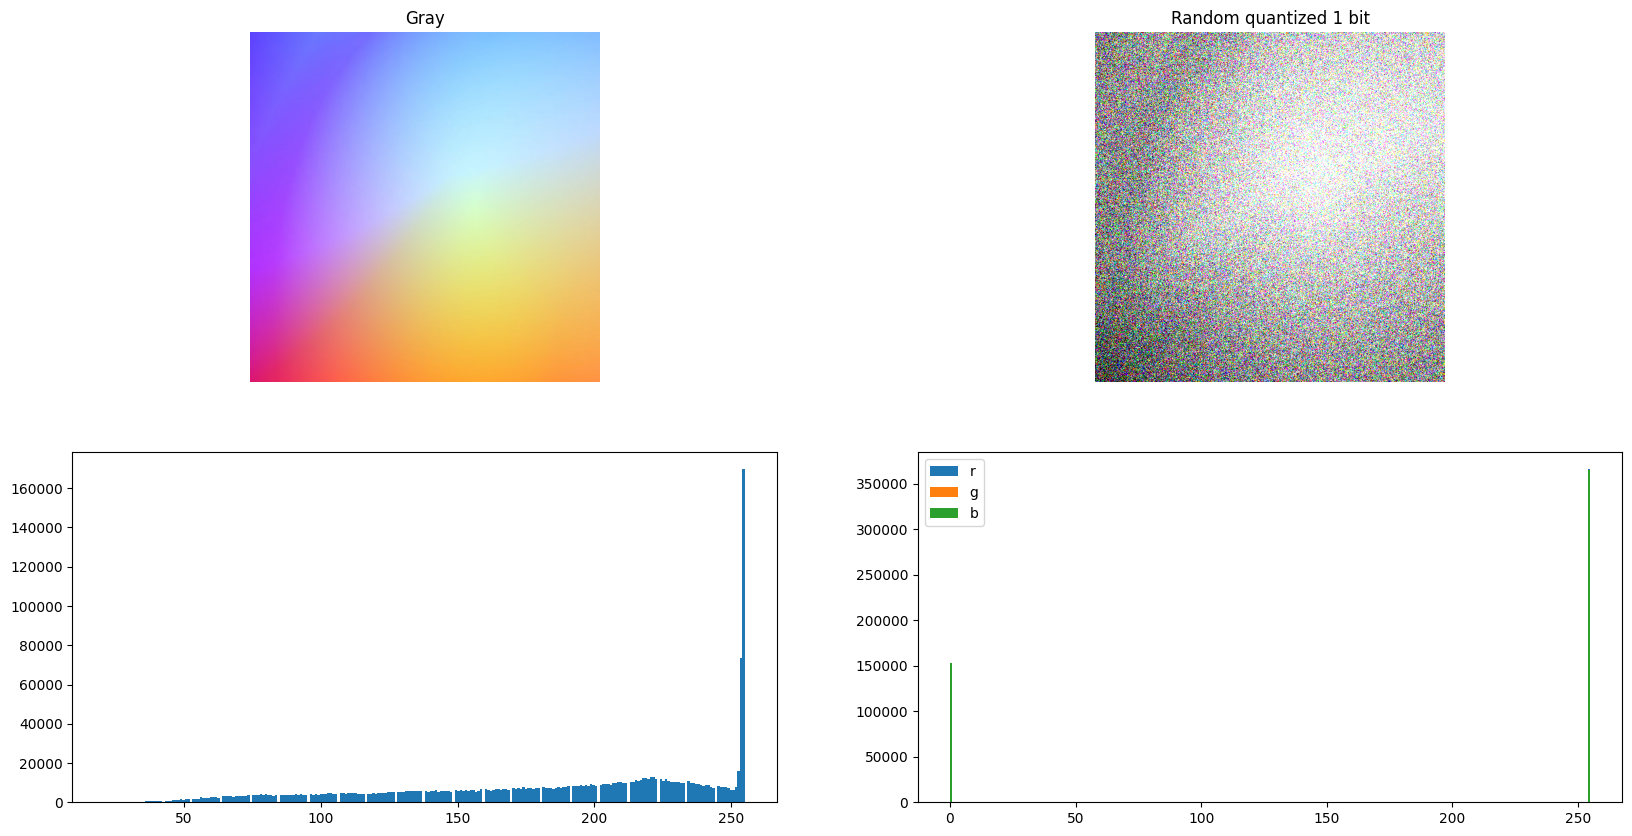

In [8]:
# level = 2
treshold = 127
image = cv2.imread(img_source)
r,g,b = cv2.split(image)
# image = cv2.merge([r,g,b])

def quantize_for_channel(channel):
    quantized_image = np.array(channel).copy()
    for i in range(gray_image.shape[0]):
        for j in range(gray_image.shape[1]):
            quantized_image[i][j] = 255 if gray_image[i][j]+np.random.randint(-127,127)>treshold else 0
    return quantized_image

channels = [r,g,b]
n_c = []
for channel in channels:
    n_c.append(quantize_for_channel(channel))
quantized_image = cv2.merge(n_c)

plt.figure(figsize=(20,10))


plt.subplot(2,2,1)
plt.imshow(image, cmap='gray')
plt.title('Gray')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(quantized_image)
plt.title(f'Random quantized 1 bit')
plt.axis('off')


plt.subplot(2,2,3)
_=plt.hist(image.ravel(), bins=256)

plt.subplot(2,2,4)
_=plt.hist(cv2.split(quantized_image)[0].ravel(), bins=256)
_=plt.hist(cv2.split(quantized_image)[1].ravel(), bins=256)
_=plt.hist(cv2.split(quantized_image)[2].ravel(), bins=256)
plt.legend(['r','g','b'])

# cv2.imwrite('images/gray_hills.jpeg',gray_image)
# cv2.imwrite('images/quantized_gray_hills.jpeg',quantized_image)

## Ordered dithering uding Bayer's matrices

[[0.     0.5    0.125  0.625 ]
 [0.75   0.25   0.875  0.375 ]
 [0.1875 0.6875 0.0625 0.5625]
 [0.9375 0.4375 0.8125 0.3125]]
[[0.     0.5    0.125  0.625 ]
 [0.75   0.25   0.875  0.375 ]
 [0.1875 0.6875 0.0625 0.5625]
 [0.9375 0.4375 0.8125 0.3125]]
[[0.     0.5    0.125  0.625 ]
 [0.75   0.25   0.875  0.375 ]
 [0.1875 0.6875 0.0625 0.5625]
 [0.9375 0.4375 0.8125 0.3125]]


Text(0.5, 1.0, 'bayers results')

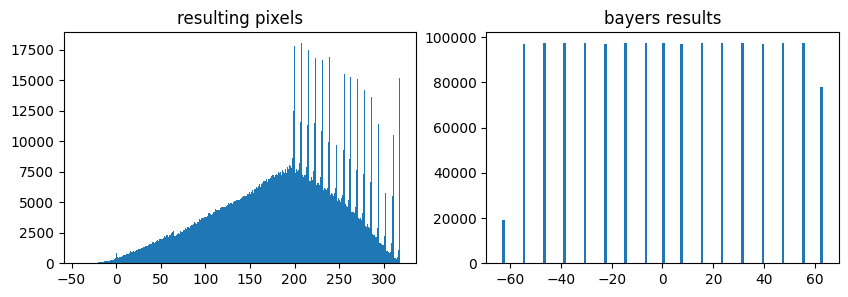

In [9]:
level = 2
# treshold = 127

# image = cv2.imread(img_source)
# gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def generate_bayer_matrix(n):
    size = 2 ** n
    matrix = [[0] * size for _ in range(size)]
    sub_size = size // 2
    sub_matrix = [[0] * sub_size for _ in range(sub_size)]
    
    sub_matrix[0][0] = 0
    sub_matrix[0][1] = 2
    sub_matrix[1][0] = 3
    sub_matrix[1][1] = 1
    
    for i in range(n - 1):
        for row in range(sub_size):
            for col in range(sub_size):
                matrix[row][col] = 4 * sub_matrix[row][col]
                matrix[row][col + sub_size] = 4 * sub_matrix[row][col] + 2
                matrix[row + sub_size][col] = 4 * sub_matrix[row][col] + 3
                matrix[row + sub_size][col + sub_size] = 4 * sub_matrix[row][col] + 1
        
        for row in range(sub_size):
            for col in range(sub_size):
                sub_matrix[row][col] = matrix[row][col]

    return np.array(matrix)


# for y in range(gray_image.shape[0]):
#     for x in range(gray_image.shape[1]):
#         i,j = x%n,y%n
#         e = gray_image[y][x] - int(np.floor(gray_image[y][x]/delta)*delta)
#         if(e>Dn[j][i]):
#             quantized_image[y][x] = int(np.ceil(gray_image[y][x]/delta)*delta)  
#         else:
#             quantized_image[y][x] = int(np.floor(gray_image[y][x]/delta)*delta)


statistic_pixels = []
bayer_results = []

def get_image(level, input):
    D2 = np.array([[3,1],[0,2]])
    Dn = generate_bayer_matrix(level)/2**(level*2)
    # Dn = generate_bayer_matrix(level)
    # Dn = D2; level = 1
    print(Dn)
    
    n = level**2
    quantized_image = np.array(input).copy()
    palette = np.zeros(256)
    palette[128:] = 255
    # print(palette)


    for y in range(input.shape[0]):
        for x in range(input.shape[1]):
            i,j = y%n,x%n
            
            multiplyier = 1
            # if(input[y][x]>256/level):
            if(input[y][x]+Dn[i][j] > 256/level):
                multiplyier = -1
                
            bayer_results.append(int(multiplyier*(255/(level))*(Dn[i][j] - 1/2)))
            new_val = int(input[y][x] + multiplyier*(255/(level))*(Dn[i][j] - 1/2))
            statistic_pixels.append(new_val)
            # print(new_val)
            if(new_val >=256):
                new_val = 255
            elif(new_val <=0):
                new_val = 0
            quantized_image[y][x] = palette[new_val]
        
    return quantized_image
    
image = cv2.imread(img_source)
r,g,b = cv2.split(image)
channels = [r,g,b]
n_c = []
for channel in channels:
    n_c.append(get_image(2, channel))
quantized_image = cv2.merge(n_c)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
_=plt.hist(np.array(statistic_pixels).ravel(), bins=(max(statistic_pixels) - min(statistic_pixels)))
plt.title('resulting pixels')

plt.subplot(1,2,2);
_=plt.hist(np.array(bayer_results).ravel(), bins=(max(bayer_results) - min(bayer_results)))
plt.title('bayers results')

False

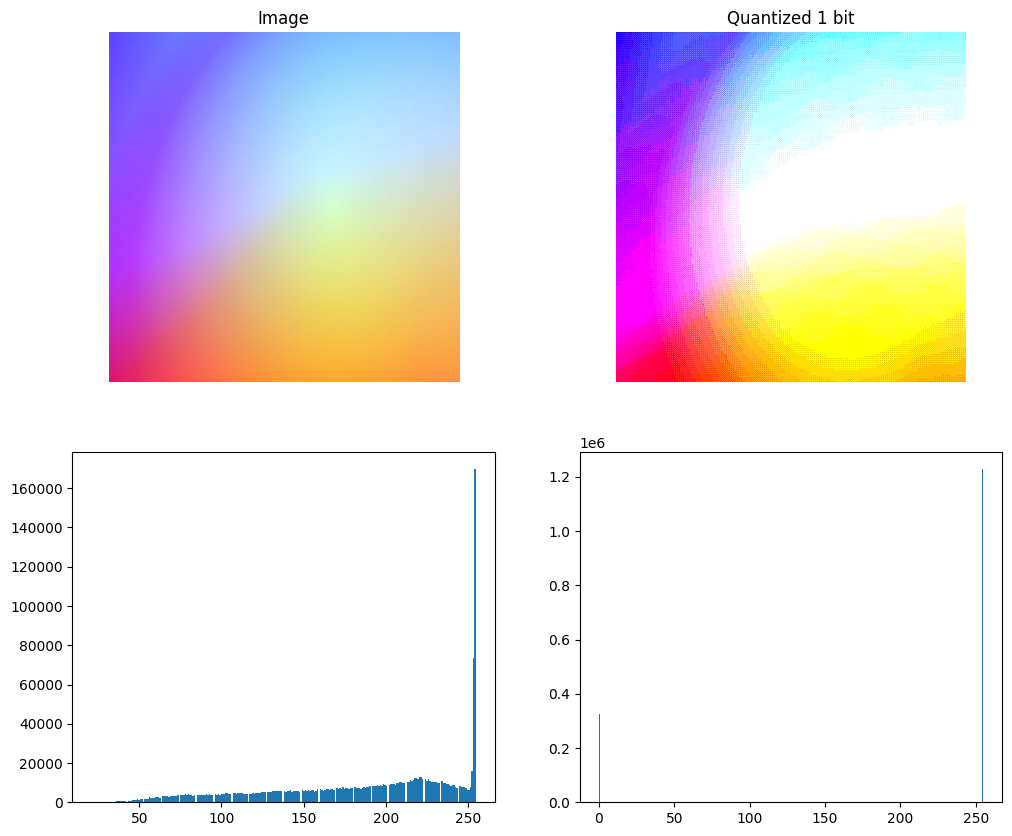

In [10]:
plt.figure(figsize=(12,10))


plt.subplot(2,2,1)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(quantized_image, cmap='gray')
plt.title(f'Quantized 1 bit')
plt.axis('off')


plt.subplot(2,2,3)
_=plt.hist(image.ravel(), bins=256)

plt.subplot(2,2,4)
_=plt.hist(quantized_image.ravel(), bins=256)

cv2.imwrite(f'images/gray_{img_source}.png',gray_image)
cv2.imwrite(f'images/ordered_dith_gray_{img_source}.png',quantized_image)

## Error Diffusion - Floyd-Steinberg Algorithm

[[0.36078431 0.36078431 0.36078431 ... 0.50980392 0.50980392 0.50980392]
 [0.         1.         0.         ... 1.         0.         0.66961247]
 [0.         0.         1.         ... 0.         1.         0.49712872]
 ...
 [1.         1.         1.         ... 1.         1.         0.80913688]
 [1.         1.         0.         ... 1.         1.         0.79810257]
 [0.66867608 0.77856548 0.94630646 ... 0.80028221 0.88595339 0.919685  ]]
[[ 0.27058824  0.27058824  0.27058824 ...  0.7372549   0.7372549
   0.7372549 ]
 [ 0.          0.          0.         ...  1.          1.
   0.53290696]
 [ 0.          1.          0.         ...  0.          1.
   0.6251672 ]
 ...
 [ 0.          0.          0.         ...  0.          1.
   0.57132559]
 [ 0.          0.          1.         ...  0.          1.
   0.5062815 ]
 [ 0.23015337  0.13605542 -0.0073987  ...  0.65219113  0.53238175
   0.60439705]]
[[1.         1.         1.         ... 0.99607843 0.99607843 0.99607843]
 [1.         1.         

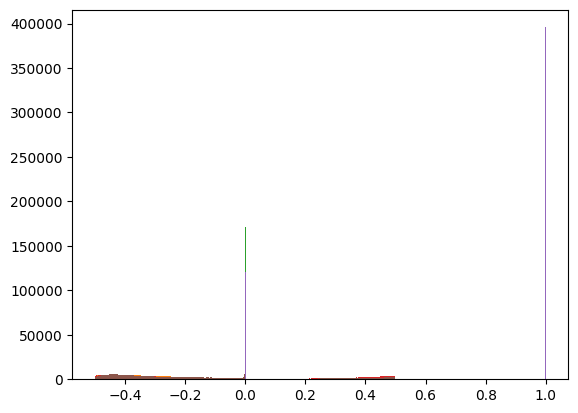

In [11]:
level = 2
# treshold = 127

image = cv2.imread(img_source)
# gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


def trunc(val, level):
    palette = np.zeros(256)
    palette[127:] = 255
    # nearest_palette_pixel = int(val // 255)
    # print(nearest_palette_pixel)
    return np.round(val/(level-1))*(level-1)

def get_image(level, input):
    
    alpha, delta, gamma, beta = 7/16, 1/16, 5/16, 3/16
    # old_pixel = input.copy()
    pixels = input.copy() /255
    newpixels = []
    q_ers = []
    for x in range(1, pixels.shape[0]-1):
        for y in range(pixels.shape[1]-1):
            oldpixel = pixels[x][y]
            newpixel = trunc(oldpixel, level)
            newpixels.append(newpixel)
            pixels[x][y] = newpixel
            quant_error = oldpixel - newpixel
            q_ers.append(quant_error)
            pixels[x][y+1] += quant_error *alpha
            pixels[x+1][y-1] += quant_error *beta
            pixels[x+1][y] += quant_error *gamma
            pixels[x+1][y+1] += quant_error *delta

    _=plt.hist(np.array(newpixels).ravel(), bins=256)
    _=plt.hist(np.array(q_ers).ravel(), bins=256)
    print(pixels)
    return pixels/np.max(pixels, axis=(0,1)) * 255
 
image = cv2.imread(img_source)
r,g,b = cv2.split(image)
channels = [r,g,b]
n_c = []
for channel in channels:
    n_c.append(get_image(2, channel))
quantized_image = cv2.merge(n_c)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


False

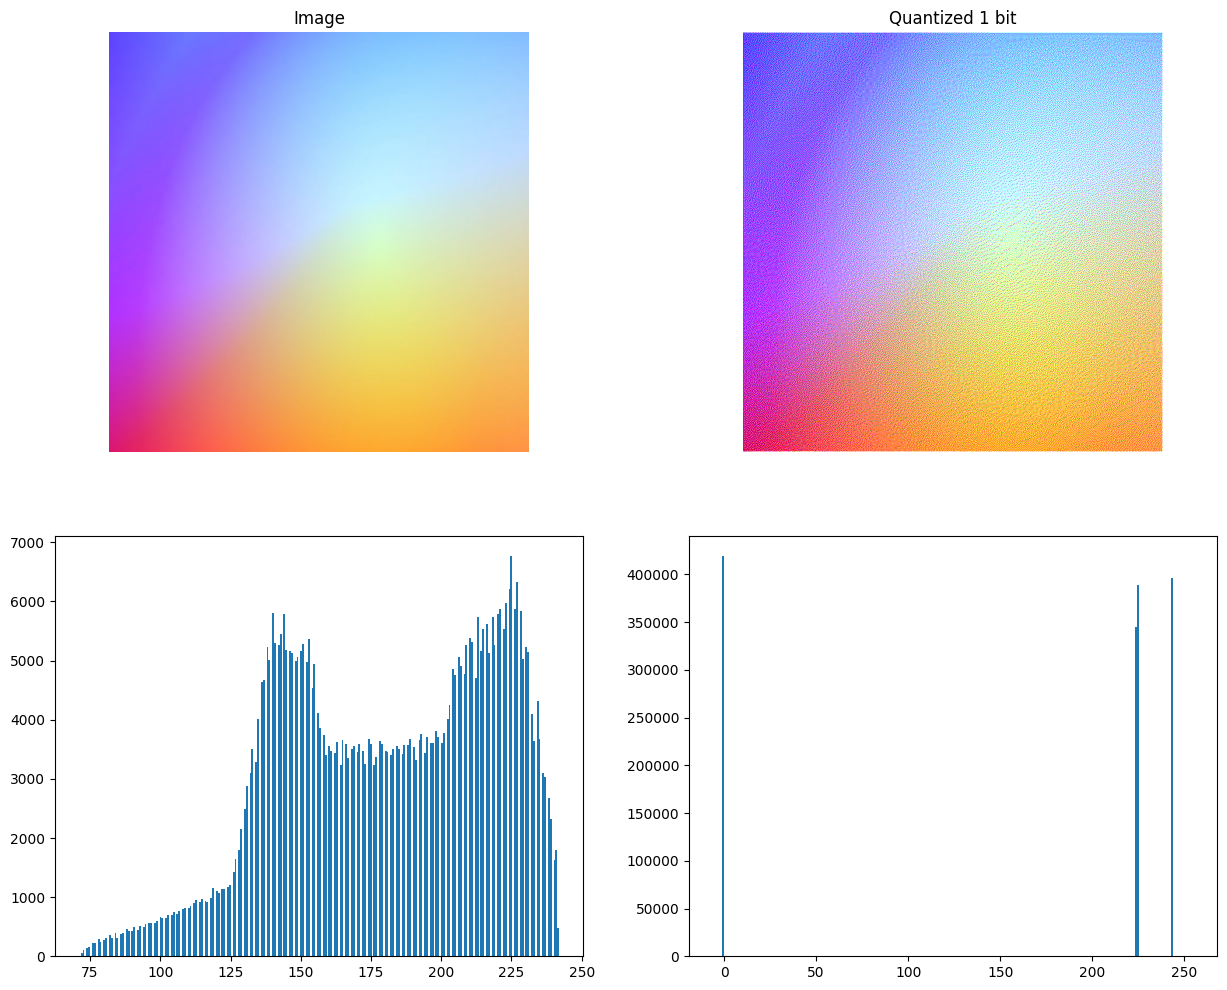

In [12]:
plt.figure(figsize=(15,12))


plt.subplot(2,2,1)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(quantized_image, cmap='gray')
plt.title(f'Quantized 1 bit')
plt.axis('off')


plt.subplot(2,2,3)
_=plt.hist(gray_image.ravel(), bins=256)

plt.subplot(2,2,4)
_=plt.hist(quantized_image.ravel(), bins=256)

cv2.imwrite(f'images/err_dif_dith_gray_{img_source}.png',quantized_image)


# Sources
>Median cut:
> - https://web.archive.org/web/20190202154003/http://www.leptonica.com/papers/mediancut.pdf
> - https://www.researchgate.net/publication/26339916_Optimal_image_quantization_perception_and_the_median_cut_algorithm
>
>Ordered:
> - https://www.cs.princeton.edu/courses/archive/fall00/cs426/lectures/dither/dither.pdf
> - https://en.wikipedia.org/wiki/Ordered_dithering
> - https://medium.com/the-bkpt/dithered-shading-tutorial-29f57d06ac39
>
>Floyd-Steinberg
> - https://scipython.com/blog/floyd-steinberg-dithering/
> - https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering

---
## Plan
Quantization:
  - Uniform Quantization
  - Random dither
  - Ordered dither using Bayer's matrix
  - Floyd-Steinberg dither